In [1]:
import pandas as pd
import numpy as np
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces

X,y = fetch_olivetti_faces(return_X_y=True)

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(X)

In [3]:
X_pca.shape

(400, 260)

In [4]:
from sklearn.model_selection import train_test_split
# Given the scarcity of the dataset, an 80-20 ratio for train/test will be considered.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=True,random_state=42,stratify=y)

In [5]:
input_size = X_pca.shape[1]
    
def mkmodel(top_size, center_size, regularization_rate):
    # Encoder
    encoder_input = tf.keras.layers.Input(shape=(input_size,))
    layer = tf.keras.layers.Dense(top_size, activation='tanh')(encoder_input)
    mean = tf.keras.layers.Dense(center_size, activation='relu', 
                                 kernel_regularizer=tf.keras.regularizers.l2(l=regularization_rate))(layer)
    var = tf.keras.layers.Dense(center_size, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.l2(l=regularization_rate))(layer)
    encoder_model = tf.keras.models.Model([encoder_input], [mean, var])

    # Decoder
    decoder_input = tf.keras.layers.Input((center_size,))
    layer = tf.keras.layers.Dense(top_size, activation='relu', kernel_regularizer=
                                  tf.keras.regularizers.l2(l=regularization_rate))(decoder_input)
    layer = tf.keras.layers.Dense(input_size)(layer)
    decoder_model = tf.keras.models.Model(decoder_input, layer)

    # Reparameterization Trick
    mean, var = encoder_model(encoder_input)
    epsilon = tf.random.normal(shape=(tf.shape(var)[0],tf.shape(var)[1]))
    z = mean + tf.exp(var) * epsilon
    decoder_output = decoder_model(z)
    model = tf.keras.models.Model(encoder_input, decoder_output)
    
#     loss = K.abs(decoder_output - encoder_input)
#     model.add_loss(loss)
    
    return model, decoder_model, encoder_model

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

# With 8 samples available for each person for training, We set the n_splits=4 , so for each split, we'll
# have 6 records per person to train and 2 record to validate with.
skf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)

top_layers = [180,130]
center_layers = [90,65]
regularization_rates = [0.001,0.005]
learning_rates = [0.01,0.001]

best_params = {
    "loss": np.Inf
}

for top in top_layers:
    for center in center_layers:
        for r in regularization_rates:
            for l in learning_rates:
                model,decoder,encoder = mkmodel(top, center, r)
                model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(l))
                losses = []
                for fit_idx, val_idx in skf.split(X_train,y_train):
                    X_fit, X_val = X_train[fit_idx], X_train[val_idx]
                    history = model.fit(X_fit,X_fit,epochs=50,validation_data=(X_val, X_val))
                    losses.append(history.history['val_loss'])
                loss = np.mean(losses)
                if best_params['loss'] > loss:
                    best_params['loss'] = loss
                    best_params['model'] = model
                    best_params['learning_rate'] = l
                    best_params['regularization_rate'] = r
                    best_params['n_top_layer'] = top
                    best_params['n_center_layer'] = center


Epoch 1/50
8/8 [==============================] - 2s 70ms/step - loss: 0.8900 - val_loss: 0.5908
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.5497 - val_loss: 0.4740
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.4519 - val_loss: 0.3861
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.3632 - val_loss: 0.3093
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2955 - val_loss: 0.2661
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2566 - val_loss: 0.2375
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2282 - val_loss: 0.2207
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2142 - val_loss: 0.2067
Epoch 9/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2051 - val_loss: 0.1996
Epoch 10/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1960 - val_loss: 0.1985
Epoch 11/50
8/8 [============

Epoch 35/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1408 - val_loss: 0.1564
Epoch 36/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1396 - val_loss: 0.1600
Epoch 37/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1397 - val_loss: 0.1555
Epoch 38/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1406 - val_loss: 0.1575
Epoch 39/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1399 - val_loss: 0.1538
Epoch 40/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1391 - val_loss: 0.1563
Epoch 41/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1408 - val_loss: 0.1572
Epoch 42/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1387 - val_loss: 0.1557
Epoch 43/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1374 - val_loss: 0.1572
Epoch 44/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1360 - val_loss: 0.1569
Epoch 45/50
8/8 [===

8/8 [==============================] - 0s 20ms/step - loss: 0.1352 - val_loss: 0.1467
Epoch 19/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1348 - val_loss: 0.1465
Epoch 20/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1321 - val_loss: 0.1454
Epoch 21/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1307 - val_loss: 0.1461
Epoch 22/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1301 - val_loss: 0.1455
Epoch 23/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1314 - val_loss: 0.1461
Epoch 24/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1333 - val_loss: 0.1445
Epoch 25/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1356 - val_loss: 0.1512
Epoch 26/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1325 - val_loss: 0.1473
Epoch 27/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1324 - val_loss: 0.1473
Epoch 28/50
8/8 [===============

Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1865 - val_loss: 0.1816
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1832 - val_loss: 0.1808
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1825 - val_loss: 0.1810
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1803 - val_loss: 0.1799
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1776 - val_loss: 0.1808
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1762 - val_loss: 0.1776
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1769 - val_loss: 0.1778
Epoch 9/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1728 - val_loss: 0.1786
Epoch 10/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1714 - val_loss: 0.1747
Epoch 11/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1707 - val_loss: 0.1751
Epoch 12/50
8/8 [===========

Epoch 36/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1292 - val_loss: 0.1409
Epoch 37/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1306 - val_loss: 0.1443
Epoch 38/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1296 - val_loss: 0.1419
Epoch 39/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1288 - val_loss: 0.1447
Epoch 40/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1272 - val_loss: 0.1433
Epoch 41/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1284 - val_loss: 0.1432
Epoch 42/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1275 - val_loss: 0.1441
Epoch 43/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1272 - val_loss: 0.1440
Epoch 44/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1270 - val_loss: 0.1452
Epoch 45/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1264 - val_loss: 0.1433
Epoch 46/50
8/8 [===

Epoch 20/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2178 - val_loss: 0.2231
Epoch 21/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2176 - val_loss: 0.2171
Epoch 22/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2115 - val_loss: 0.2163
Epoch 23/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2113 - val_loss: 0.2197
Epoch 24/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2116 - val_loss: 0.2254
Epoch 25/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2114 - val_loss: 0.2132
Epoch 26/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2095 - val_loss: 0.2153
Epoch 27/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2071 - val_loss: 0.2151
Epoch 28/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2112 - val_loss: 0.2166
Epoch 29/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2082 - val_loss: 0.2129
Epoch 30/50
8/8 [===

8/8 [==============================] - 0s 17ms/step - loss: 0.1845 - val_loss: 0.1945
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1882 - val_loss: 0.1874
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1826 - val_loss: 0.1870
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1814 - val_loss: 0.1881
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1799 - val_loss: 0.1851
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1805 - val_loss: 0.1840
Epoch 9/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1851 - val_loss: 0.1865
Epoch 10/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1810 - val_loss: 0.1850
Epoch 11/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1797 - val_loss: 0.1855
Epoch 12/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1768 - val_loss: 0.1900
Epoch 13/50
8/8 [=====================

8/8 [==============================] - 0s 17ms/step - loss: 0.1694 - val_loss: 0.1840
Epoch 37/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1699 - val_loss: 0.1810
Epoch 38/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1714 - val_loss: 0.1825
Epoch 39/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1725 - val_loss: 0.1795
Epoch 40/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1702 - val_loss: 0.1847
Epoch 41/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1686 - val_loss: 0.1851
Epoch 42/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1713 - val_loss: 0.1833
Epoch 43/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1698 - val_loss: 0.1807
Epoch 44/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1699 - val_loss: 0.1825
Epoch 45/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1738 - val_loss: 0.1915
Epoch 46/50
8/8 [===============

Epoch 20/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2009 - val_loss: 0.1988
Epoch 21/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2016 - val_loss: 0.1972
Epoch 22/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2007 - val_loss: 0.1998
Epoch 23/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1998 - val_loss: 0.1988
Epoch 24/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2007 - val_loss: 0.1978
Epoch 25/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1988 - val_loss: 0.1994
Epoch 26/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2002 - val_loss: 0.1995
Epoch 27/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1989 - val_loss: 0.1982
Epoch 28/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1995 - val_loss: 0.1935
Epoch 29/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1982 - val_loss: 0.1948
Epoch 30/50
8/8 [===

8/8 [==============================] - 0s 17ms/step - loss: 0.1805 - val_loss: 0.1846
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1782 - val_loss: 0.1866
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1789 - val_loss: 0.1863
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1799 - val_loss: 0.1896
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1804 - val_loss: 0.1896
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1811 - val_loss: 0.1909
Epoch 9/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1788 - val_loss: 0.1851
Epoch 10/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1775 - val_loss: 0.1877
Epoch 11/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1779 - val_loss: 0.1867
Epoch 12/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1782 - val_loss: 0.1871
Epoch 13/50
8/8 [=====================

Epoch 37/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1511 - val_loss: 0.1687
Epoch 38/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1478 - val_loss: 0.1699
Epoch 39/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1472 - val_loss: 0.1690
Epoch 40/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1465 - val_loss: 0.1716
Epoch 41/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1451 - val_loss: 0.1680
Epoch 42/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1423 - val_loss: 0.1689
Epoch 43/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1418 - val_loss: 0.1666
Epoch 44/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1432 - val_loss: 0.1708
Epoch 45/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1426 - val_loss: 0.1680
Epoch 46/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1397 - val_loss: 0.1697
Epoch 47/50
8/8 [===

8/8 [==============================] - 0s 19ms/step - loss: 0.1286 - val_loss: 0.1524
Epoch 21/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1314 - val_loss: 0.1474
Epoch 22/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1294 - val_loss: 0.1476
Epoch 23/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1299 - val_loss: 0.1438
Epoch 24/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1289 - val_loss: 0.1509
Epoch 25/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1277 - val_loss: 0.1518
Epoch 26/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1305 - val_loss: 0.1519
Epoch 27/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1291 - val_loss: 0.1498
Epoch 28/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1281 - val_loss: 0.1470
Epoch 29/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1261 - val_loss: 0.1502
Epoch 30/50
8/8 [===============

Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6517 - val_loss: 0.6234
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.6178 - val_loss: 0.5922
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5841 - val_loss: 0.5581
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.5561 - val_loss: 0.5380
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5357 - val_loss: 0.5169
Epoch 9/50
8/8 [==============================] - 0s 17ms/step - loss: 0.5131 - val_loss: 0.4979
Epoch 10/50
8/8 [==============================] - 0s 17ms/step - loss: 0.4875 - val_loss: 0.4712
Epoch 11/50
8/8 [==============================] - 0s 18ms/step - loss: 0.4670 - val_loss: 0.4504
Epoch 12/50
8/8 [==============================] - 0s 17ms/step - loss: 0.4390 - val_loss: 0.4285
Epoch 13/50
8/8 [==============================] - 0s 15ms/step - loss: 0.4199 - val_loss: 0.4119
Epoch 14/50
8/8 [=========

Epoch 38/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1453 - val_loss: 0.1605
Epoch 39/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1443 - val_loss: 0.1565
Epoch 40/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1444 - val_loss: 0.1594
Epoch 41/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1436 - val_loss: 0.1574
Epoch 42/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1441 - val_loss: 0.1552
Epoch 43/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1422 - val_loss: 0.1565
Epoch 44/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1407 - val_loss: 0.1581
Epoch 45/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1413 - val_loss: 0.1557
Epoch 46/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1420 - val_loss: 0.1576
Epoch 47/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1407 - val_loss: 0.1559
Epoch 48/50
8/8 [===

Epoch 22/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1196 - val_loss: 0.1322
Epoch 23/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1196 - val_loss: 0.1326
Epoch 24/50
8/8 [==============================] - ETA: 0s - loss: 0.121 - 0s 17ms/step - loss: 0.1194 - val_loss: 0.1324
Epoch 25/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1190 - val_loss: 0.1319
Epoch 26/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1182 - val_loss: 0.1347
Epoch 27/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1181 - val_loss: 0.1333
Epoch 28/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1183 - val_loss: 0.1316
Epoch 29/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1188 - val_loss: 0.1316
Epoch 30/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1177 - val_loss: 0.1337
Epoch 31/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1171 - val_loss: 0.1

8/8 [==============================] - 0s 16ms/step - loss: 0.1965 - val_loss: 0.1957
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1941 - val_loss: 0.1930
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1927 - val_loss: 0.1855
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1902 - val_loss: 0.1926
Epoch 9/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1916 - val_loss: 0.1946
Epoch 10/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1890 - val_loss: 0.1887
Epoch 11/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1858 - val_loss: 0.1916
Epoch 12/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1883 - val_loss: 0.1906
Epoch 13/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1894 - val_loss: 0.1887
Epoch 14/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1862 - val_loss: 0.1847
Epoch 15/50
8/8 [===================

Epoch 39/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1723 - val_loss: 0.1907
Epoch 40/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1708 - val_loss: 0.1840
Epoch 41/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1715 - val_loss: 0.1891
Epoch 42/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1726 - val_loss: 0.1835
Epoch 43/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1732 - val_loss: 0.1901
Epoch 44/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1757 - val_loss: 0.1839
Epoch 45/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1751 - val_loss: 0.1829
Epoch 46/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1778 - val_loss: 0.1914
Epoch 47/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1750 - val_loss: 0.1842
Epoch 48/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1729 - val_loss: 0.1845
Epoch 49/50
8/8 [===

Epoch 23/50
8/8 [==============================] - 0s 19ms/step - loss: 0.3134 - val_loss: 0.3012
Epoch 24/50
8/8 [==============================] - 0s 16ms/step - loss: 0.3016 - val_loss: 0.2906
Epoch 25/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2889 - val_loss: 0.2786
Epoch 26/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2768 - val_loss: 0.2696
Epoch 27/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2692 - val_loss: 0.2617
Epoch 28/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2621 - val_loss: 0.2571
Epoch 29/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2557 - val_loss: 0.2509
Epoch 30/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2487 - val_loss: 0.2491
Epoch 31/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2448 - val_loss: 0.2457
Epoch 32/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2411 - val_loss: 0.2375
Epoch 33/50
8/8 [===

Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1885 - val_loss: 0.1947
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1874 - val_loss: 0.1937
Epoch 9/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1879 - val_loss: 0.1927
Epoch 10/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1878 - val_loss: 0.1904
Epoch 11/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1863 - val_loss: 0.1944
Epoch 12/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1849 - val_loss: 0.1926
Epoch 13/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1851 - val_loss: 0.1961
Epoch 14/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1853 - val_loss: 0.1891
Epoch 15/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1846 - val_loss: 0.1921
Epoch 16/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1875 - val_loss: 0.1908
Epoch 17/50
8/8 [======

8/8 [==============================] - 0s 17ms/step - loss: 0.1716 - val_loss: 0.1875
Epoch 41/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1728 - val_loss: 0.1841
Epoch 42/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1715 - val_loss: 0.1818
Epoch 43/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1695 - val_loss: 0.1817
Epoch 44/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1710 - val_loss: 0.1830
Epoch 45/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1707 - val_loss: 0.1825
Epoch 46/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1730 - val_loss: 0.1852
Epoch 47/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1706 - val_loss: 0.1847
Epoch 48/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1704 - val_loss: 0.1841
Epoch 49/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1687 - val_loss: 0.1841
Epoch 50/50
8/8 [===============

Epoch 24/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1466 - val_loss: 0.1596
Epoch 25/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1497 - val_loss: 0.1673
Epoch 26/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1498 - val_loss: 0.1658
Epoch 27/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1464 - val_loss: 0.1629
Epoch 28/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1455 - val_loss: 0.1607
Epoch 29/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1444 - val_loss: 0.1594
Epoch 30/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1402 - val_loss: 0.1575
Epoch 31/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1413 - val_loss: 0.1595
Epoch 32/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1412 - val_loss: 0.1624
Epoch 33/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1443 - val_loss: 0.1585
Epoch 34/50
8/8 [===

8/8 [==============================] - 0s 17ms/step - loss: 0.1383 - val_loss: 0.1485
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1389 - val_loss: 0.1474
Epoch 9/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1355 - val_loss: 0.1432
Epoch 10/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1368 - val_loss: 0.1474
Epoch 11/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1376 - val_loss: 0.1442
Epoch 12/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1361 - val_loss: 0.1500
Epoch 13/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1378 - val_loss: 0.1486
Epoch 14/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1372 - val_loss: 0.1497
Epoch 15/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1356 - val_loss: 0.1467
Epoch 16/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1344 - val_loss: 0.1470
Epoch 17/50
8/8 [=================

Epoch 41/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2217 - val_loss: 0.2274
Epoch 42/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2177 - val_loss: 0.2254
Epoch 43/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2160 - val_loss: 0.2234
Epoch 44/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2119 - val_loss: 0.2209
Epoch 45/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2100 - val_loss: 0.2178
Epoch 46/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2087 - val_loss: 0.2146
Epoch 47/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2043 - val_loss: 0.2140
Epoch 48/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2025 - val_loss: 0.2114
Epoch 49/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1997 - val_loss: 0.2109
Epoch 50/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1977 - val_loss: 0.2043
Epoch 1/50
8/8 [====

Epoch 25/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1453 - val_loss: 0.1563
Epoch 26/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1457 - val_loss: 0.1555
Epoch 27/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1455 - val_loss: 0.1580
Epoch 28/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1433 - val_loss: 0.1539
Epoch 29/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1441 - val_loss: 0.1549
Epoch 30/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1455 - val_loss: 0.1559
Epoch 31/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1444 - val_loss: 0.1568
Epoch 32/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1440 - val_loss: 0.1547
Epoch 33/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1432 - val_loss: 0.1552
Epoch 34/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1426 - val_loss: 0.1553
Epoch 35/50
8/8 [===

Epoch 9/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2510 - val_loss: 0.2434
Epoch 10/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2425 - val_loss: 0.2368
Epoch 11/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2378 - val_loss: 0.2355
Epoch 12/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2383 - val_loss: 0.2328
Epoch 13/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2365 - val_loss: 0.2288
Epoch 14/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2314 - val_loss: 0.2351
Epoch 15/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2346 - val_loss: 0.2324
Epoch 16/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2311 - val_loss: 0.2263
Epoch 17/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2298 - val_loss: 0.2284
Epoch 18/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2252 - val_loss: 0.2263
Epoch 19/50
8/8 [====

8/8 [==============================] - 0s 16ms/step - loss: 0.1894 - val_loss: 0.1930
Epoch 43/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1911 - val_loss: 0.1921
Epoch 44/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1929 - val_loss: 0.1980
Epoch 45/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1891 - val_loss: 0.1953
Epoch 46/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1855 - val_loss: 0.1892
Epoch 47/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1855 - val_loss: 0.1897
Epoch 48/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1868 - val_loss: 0.1922
Epoch 49/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1842 - val_loss: 0.1906
Epoch 50/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1844 - val_loss: 0.1882
Epoch 1/50
8/8 [==============================] - 0s 25ms/step - loss: 0.1880 - val_loss: 0.1925
Epoch 2/50
8/8 [=================

Epoch 26/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1774 - val_loss: 0.1938
Epoch 27/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1816 - val_loss: 0.1903
Epoch 28/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1800 - val_loss: 0.1894
Epoch 29/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1791 - val_loss: 0.1869
Epoch 30/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1749 - val_loss: 0.1841
Epoch 31/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1791 - val_loss: 0.1894
Epoch 32/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1817 - val_loss: 0.1917
Epoch 33/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1822 - val_loss: 0.1882
Epoch 34/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1749 - val_loss: 0.1891
Epoch 35/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1766 - val_loss: 0.1858
Epoch 36/50
8/8 [===

Epoch 10/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2218 - val_loss: 0.2152
Epoch 11/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2218 - val_loss: 0.2152
Epoch 12/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2216 - val_loss: 0.2160
Epoch 13/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2208 - val_loss: 0.2146
Epoch 14/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2207 - val_loss: 0.2134
Epoch 15/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2207 - val_loss: 0.2129
Epoch 16/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2187 - val_loss: 0.2136
Epoch 17/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2192 - val_loss: 0.2131
Epoch 18/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2188 - val_loss: 0.2124
Epoch 19/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2199 - val_loss: 0.2137
Epoch 20/50
8/8 [===

8/8 [==============================] - 0s 20ms/step - loss: 0.1904 - val_loss: 0.2013
Epoch 44/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1906 - val_loss: 0.2011
Epoch 45/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1907 - val_loss: 0.1989
Epoch 46/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1908 - val_loss: 0.2012
Epoch 47/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1933 - val_loss: 0.1992
Epoch 48/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1907 - val_loss: 0.2007
Epoch 49/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1918 - val_loss: 0.2030
Epoch 50/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1891 - val_loss: 0.2011
Epoch 1/50
8/8 [==============================] - 0s 26ms/step - loss: 0.1918 - val_loss: 0.1983
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1904 - val_loss: 0.1978
Epoch 3/50
8/8 [==================

Epoch 27/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1594 - val_loss: 0.1768
Epoch 28/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1569 - val_loss: 0.1788
Epoch 29/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1562 - val_loss: 0.1757
Epoch 30/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1578 - val_loss: 0.1705
Epoch 31/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1544 - val_loss: 0.1744
Epoch 32/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1532 - val_loss: 0.1733
Epoch 33/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1548 - val_loss: 0.1737
Epoch 34/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1579 - val_loss: 0.1719
Epoch 35/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1549 - val_loss: 0.1743
Epoch 36/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1542 - val_loss: 0.1725
Epoch 37/50
8/8 [===

Epoch 11/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1371 - val_loss: 0.1492
Epoch 12/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1364 - val_loss: 0.1510
Epoch 13/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1343 - val_loss: 0.1506
Epoch 14/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1366 - val_loss: 0.1458
Epoch 15/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1351 - val_loss: 0.1547
Epoch 16/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1377 - val_loss: 0.1552
Epoch 17/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1342 - val_loss: 0.1542
Epoch 18/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1352 - val_loss: 0.1519
Epoch 19/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1363 - val_loss: 0.1519
Epoch 20/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1352 - val_loss: 0.1512
Epoch 21/50
8/8 [===

8/8 [==============================] - 0s 17ms/step - loss: 0.1298 - val_loss: 0.1540
Epoch 45/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1286 - val_loss: 0.1534
Epoch 46/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1287 - val_loss: 0.1464
Epoch 47/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1282 - val_loss: 0.1496
Epoch 48/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1289 - val_loss: 0.1502
Epoch 49/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1299 - val_loss: 0.1497
Epoch 50/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1261 - val_loss: 0.1509
Epoch 1/50
8/8 [==============================] - 2s 59ms/step - loss: 0.9224 - val_loss: 0.7814
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.7552 - val_loss: 0.6929
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.6803 - val_loss: 0.6472
Epoch 4/50
8/8 [===================

Epoch 28/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1638 - val_loss: 0.1698
Epoch 29/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1624 - val_loss: 0.1723
Epoch 30/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1635 - val_loss: 0.1712
Epoch 31/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1618 - val_loss: 0.1711
Epoch 32/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1629 - val_loss: 0.1708
Epoch 33/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1602 - val_loss: 0.1694
Epoch 34/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1600 - val_loss: 0.1725
Epoch 35/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1597 - val_loss: 0.1675
Epoch 36/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1597 - val_loss: 0.1676
Epoch 37/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1589 - val_loss: 0.1678
Epoch 38/50
8/8 [===

Epoch 12/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1361 - val_loss: 0.1447
Epoch 13/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1364 - val_loss: 0.1456
Epoch 14/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1354 - val_loss: 0.1427
Epoch 15/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1345 - val_loss: 0.1435
Epoch 16/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1339 - val_loss: 0.1431
Epoch 17/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1347 - val_loss: 0.1457
Epoch 18/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1350 - val_loss: 0.1443
Epoch 19/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1341 - val_loss: 0.1450
Epoch 20/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1340 - val_loss: 0.1452
Epoch 21/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1342 - val_loss: 0.1452
Epoch 22/50
8/8 [===

8/8 [==============================] - 0s 17ms/step - loss: 0.2023 - val_loss: 0.2076
Epoch 46/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2009 - val_loss: 0.2045
Epoch 47/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1994 - val_loss: 0.2032
Epoch 48/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1965 - val_loss: 0.2099
Epoch 49/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1978 - val_loss: 0.2078
Epoch 50/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1986 - val_loss: 0.2062
Epoch 1/50
8/8 [==============================] - 0s 28ms/step - loss: 0.2009 - val_loss: 0.1927
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2007 - val_loss: 0.2024
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2024 - val_loss: 0.1967
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2008 - val_loss: 0.1931
Epoch 5/50
8/8 [====================

Epoch 29/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1781 - val_loss: 0.1944
Epoch 30/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1746 - val_loss: 0.1863
Epoch 31/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1756 - val_loss: 0.1865
Epoch 32/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1757 - val_loss: 0.1882
Epoch 33/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1772 - val_loss: 0.1906
Epoch 34/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1797 - val_loss: 0.1880
Epoch 35/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1764 - val_loss: 0.1842
Epoch 36/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1777 - val_loss: 0.1953
Epoch 37/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1796 - val_loss: 0.1923
Epoch 38/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1800 - val_loss: 0.1889
Epoch 39/50
8/8 [===

Epoch 13/50
8/8 [==============================] - 0s 16ms/step - loss: 0.6703 - val_loss: 0.6334
Epoch 14/50
8/8 [==============================] - 0s 16ms/step - loss: 0.6238 - val_loss: 0.5883
Epoch 15/50
8/8 [==============================] - 0s 17ms/step - loss: 0.5876 - val_loss: 0.5527
Epoch 16/50
8/8 [==============================] - 0s 17ms/step - loss: 0.5496 - val_loss: 0.5203
Epoch 17/50
8/8 [==============================] - 0s 17ms/step - loss: 0.5180 - val_loss: 0.4899
Epoch 18/50
8/8 [==============================] - 0s 18ms/step - loss: 0.4887 - val_loss: 0.4637
Epoch 19/50
8/8 [==============================] - 0s 17ms/step - loss: 0.4626 - val_loss: 0.4366
Epoch 20/50
8/8 [==============================] - 0s 18ms/step - loss: 0.4336 - val_loss: 0.4113
Epoch 21/50
8/8 [==============================] - 0s 17ms/step - loss: 0.4127 - val_loss: 0.3929
Epoch 22/50
8/8 [==============================] - 0s 16ms/step - loss: 0.3922 - val_loss: 0.3765
Epoch 23/50
8/8 [===

8/8 [==============================] - 0s 17ms/step - loss: 0.2025 - val_loss: 0.2044
Epoch 47/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2025 - val_loss: 0.1999
Epoch 48/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2041 - val_loss: 0.1999
Epoch 49/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2044 - val_loss: 0.2007
Epoch 50/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2026 - val_loss: 0.1992
Epoch 1/50
8/8 [==============================] - 0s 27ms/step - loss: 0.2005 - val_loss: 0.2024
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2018 - val_loss: 0.2008
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2016 - val_loss: 0.2043
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1996 - val_loss: 0.2036
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1973 - val_loss: 0.2026
Epoch 6/50
8/8 [=====================

Epoch 30/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1848 - val_loss: 0.1951
Epoch 31/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1839 - val_loss: 0.1949
Epoch 32/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1839 - val_loss: 0.1964
Epoch 33/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1849 - val_loss: 0.1935
Epoch 34/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1863 - val_loss: 0.1974
Epoch 35/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1836 - val_loss: 0.1951
Epoch 36/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1835 - val_loss: 0.1963
Epoch 37/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1845 - val_loss: 0.1956
Epoch 38/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1817 - val_loss: 0.1977
Epoch 39/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1836 - val_loss: 0.1929
Epoch 40/50
8/8 [===

In [7]:
loss = best_params['loss']
model = best_params['model']
learning_rate = best_params['learning_rate']
regularization_rate = best_params['regularization_rate']
n_top_layer = best_params['n_top_layer']
n_center_layer = best_params['n_center_layer']

In [8]:
print('loss:', loss)
print('learning_rate:', learning_rate)
print('regularization_rate:', regularization_rate)
print('n_top_layer:', n_top_layer)
print('n_center_layer:', n_center_layer)

loss: 0.16047693662345408
learning_rate: 0.01
regularization_rate: 0.001
n_top_layer: 180
n_center_layer: 65


In [9]:
model,decoder,encoder = mkmodel(top, center, r)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(l))
history = model.fit(X_train,X_train,epochs=100,validation_data=(X_test, X_test))

Epoch 1/100
10/10 [==============================] - 1s 45ms/step - loss: 1.8734 - val_loss: 1.6737
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 1.5831 - val_loss: 1.4849
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3960 - val_loss: 1.3145
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2399 - val_loss: 1.1789
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1078 - val_loss: 1.0544
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9946 - val_loss: 0.9518
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8980 - val_loss: 0.8569
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8099 - val_loss: 0.7781
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7369 - val_loss: 0.7051
Epoch 10/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6724 - val_loss: 0.6477

10/10 [==============================] - 0s 13ms/step - loss: 0.1991 - val_loss: 0.2010
Epoch 83/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1968 - val_loss: 0.2011
Epoch 84/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1969 - val_loss: 0.1997
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1971 - val_loss: 0.1973
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1963 - val_loss: 0.1980
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1964 - val_loss: 0.1990
Epoch 88/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1954 - val_loss: 0.1969
Epoch 89/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1962 - val_loss: 0.1966
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1967 - val_loss: 0.1970
Epoch 91/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1970 - val_loss: 0.1959
Epo

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

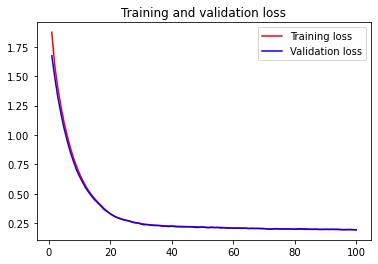

In [11]:
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

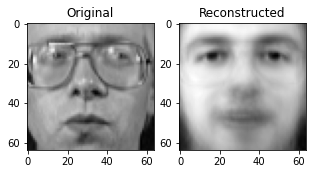

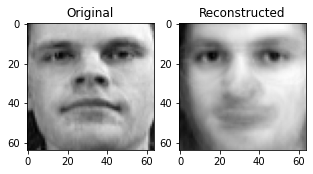

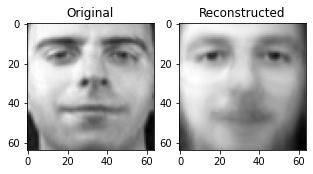

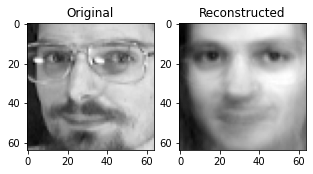

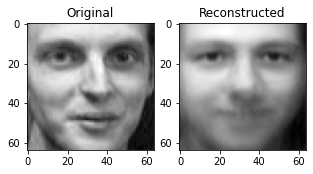

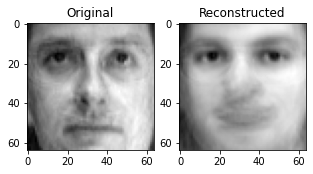

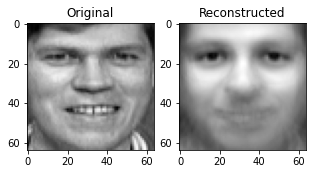

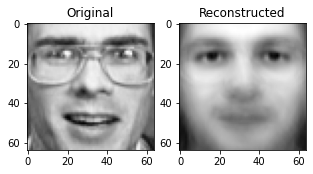

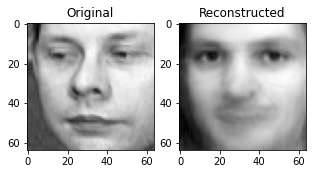

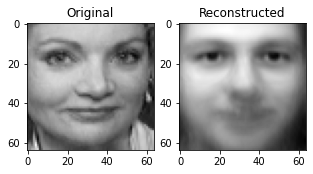

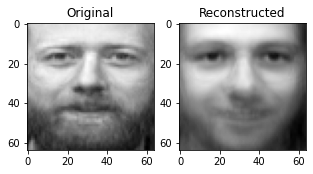

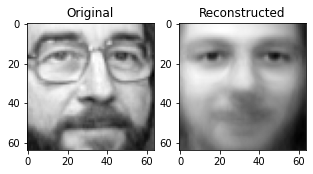

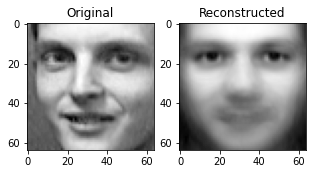

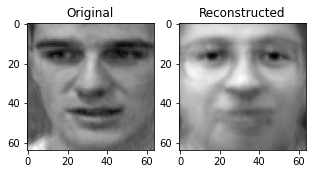

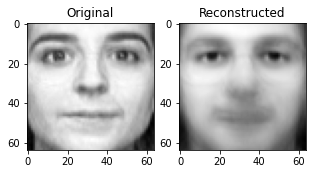

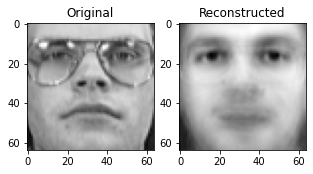

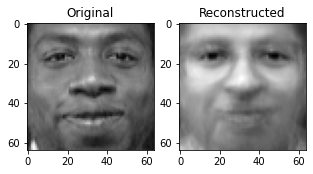

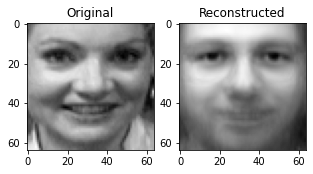

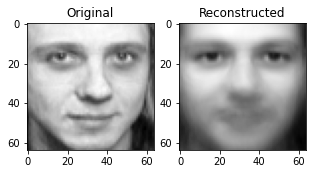

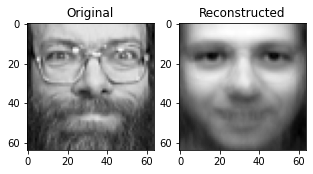

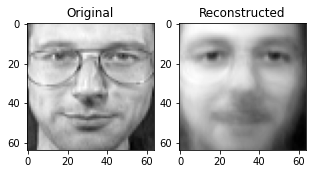

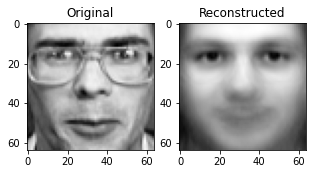

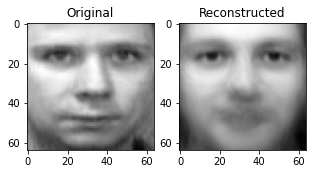

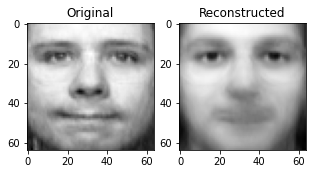

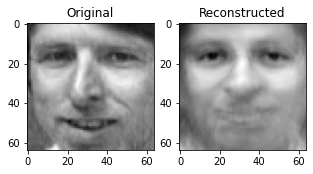

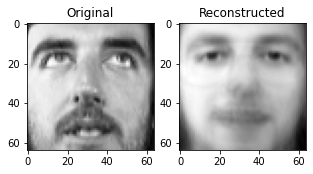

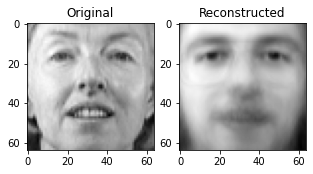

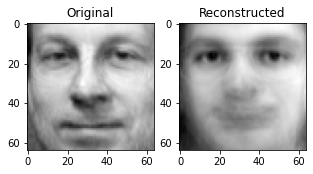

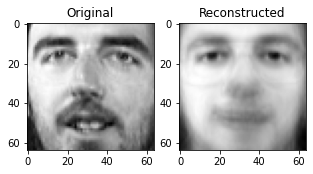

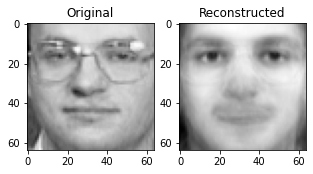

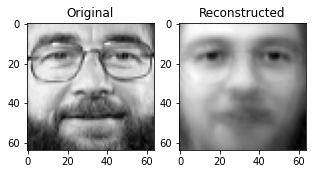

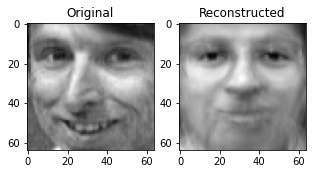

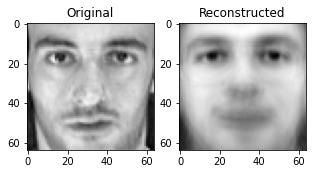

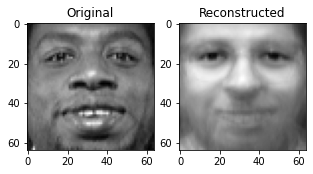

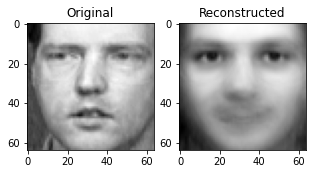

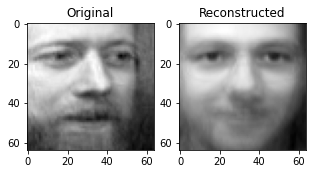

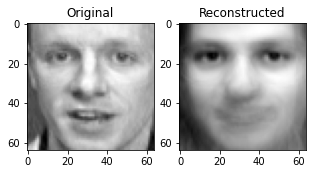

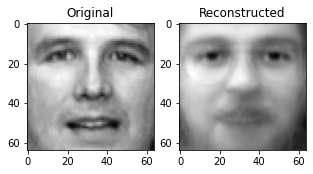

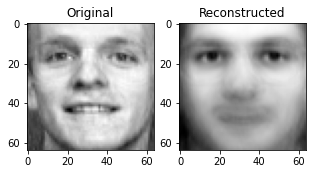

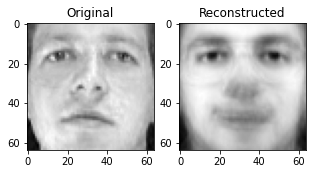

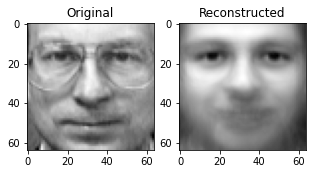

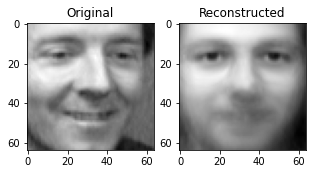

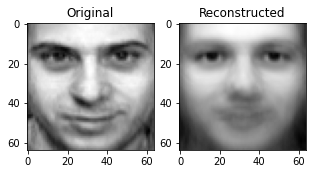

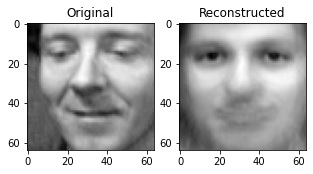

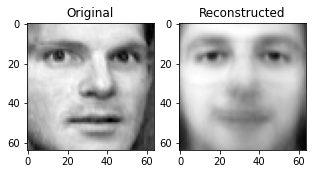

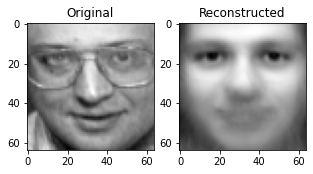

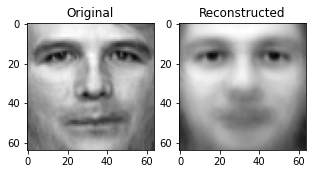

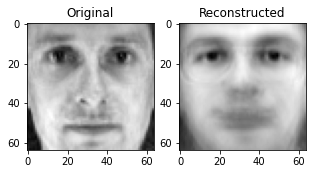

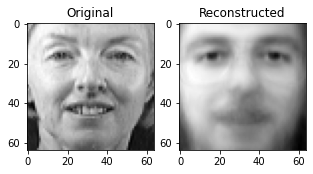

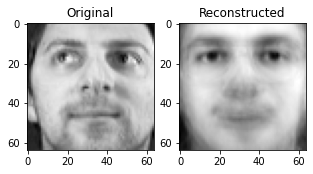

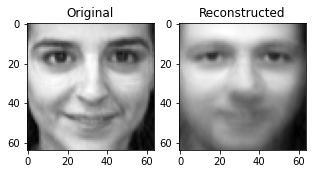

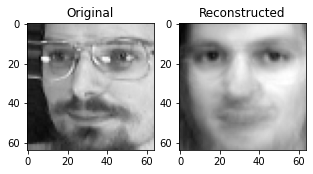

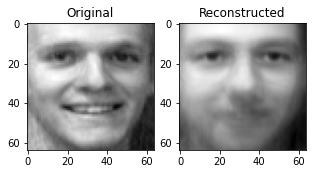

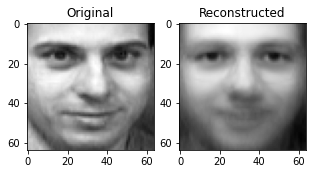

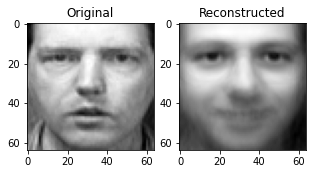

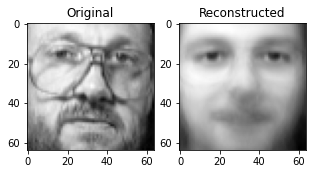

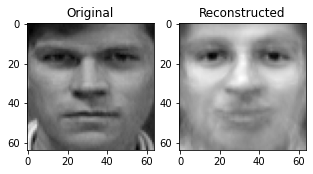

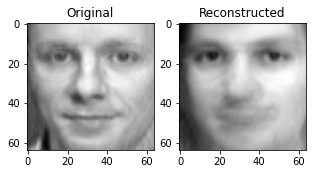

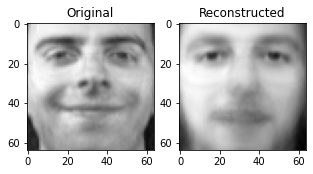

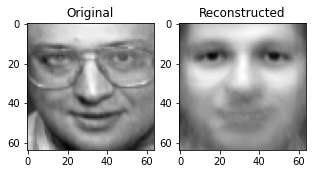

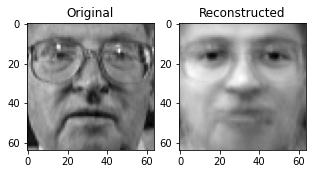

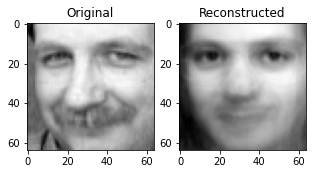

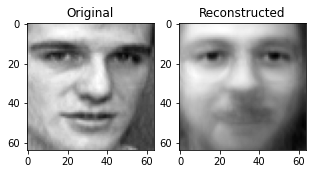

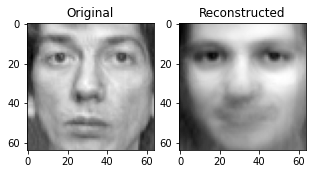

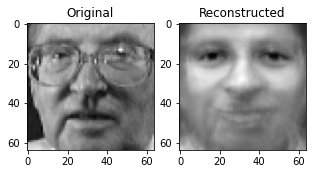

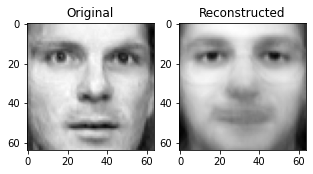

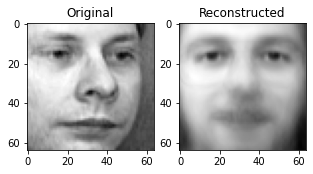

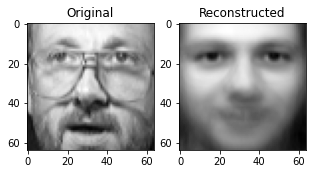

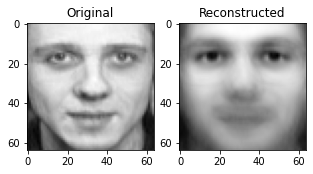

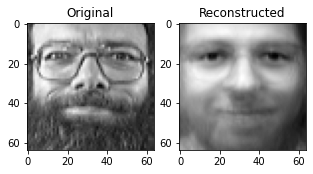

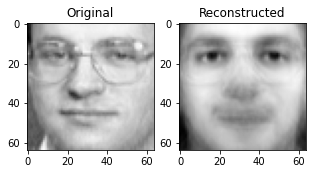

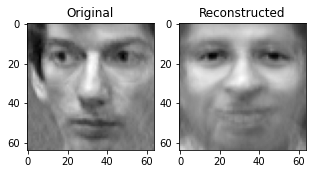

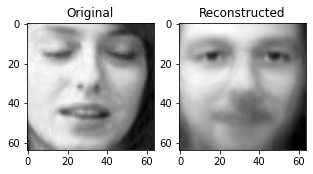

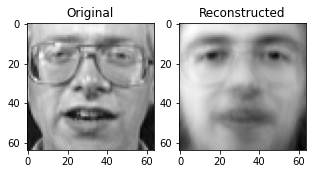

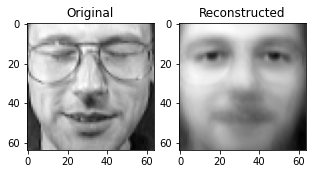

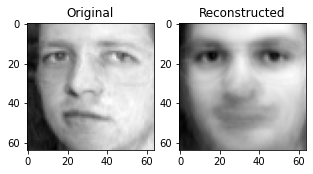

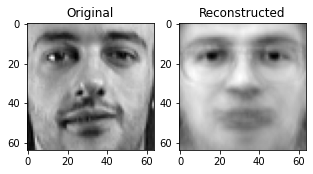

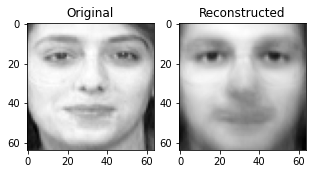

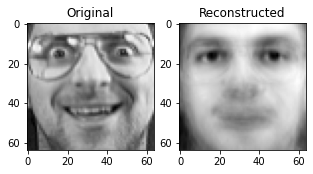

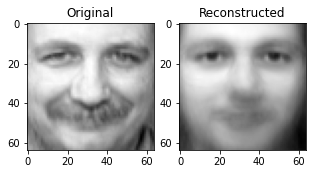

In [12]:
faces_decoded = model.predict(X_test)
for i in range(len(X_test)):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,5))
    
    original = pca.inverse_transform([X_test[i]])[0].reshape(64,64)
    ax1.imshow(original, cmap="gray")
    ax1.set_title("Original")
    
    reconstructed = pca.inverse_transform([faces_decoded[i]])[0].reshape(64,64)
    ax2.imshow(reconstructed, cmap="gray")
    ax2.set_title("Reconstructed")

    
    plt.show()